In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/mva/remotesensing

/content/drive/MyDrive/mva/remotesensing


In [3]:
!pip install geopandas rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 113.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import json

#### Loading an image using rasterio

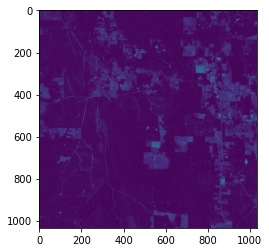

In [5]:
# Get path to raster
path_to_raster = "data/sentinel-2/tx=37,ty=-332/20221010_B04.tif"
raster =  rasterio.open(path_to_raster)

# using the read function from rasterio you can read any bands contained in the raster
# Every raster a single-channelled in this cases study, you can then read the content of the
# raster as follows
red = raster.read(1)/10_000
plt.imshow(red)

#### Creating indices

A common processing step used in remote sensing is to work on indices rather than row data. This allows us to reduce the impact of the atmosphere and easily access meaningful features. Feel free to check https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/ to get more insights on the most common indices 

In [ ]:
import cv2

In [ ]:
def get_index(band1, band2):
    shape_1 = band1.shape
    shape_2 = band2.shape
    if np.sum(shape_1)>np.sum(shape_2):
        band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
    if np.sum(shape_2)>np.sum(shape_2):
        band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
    return (band1 - band2) / (band1 + band2 + 1e-5)


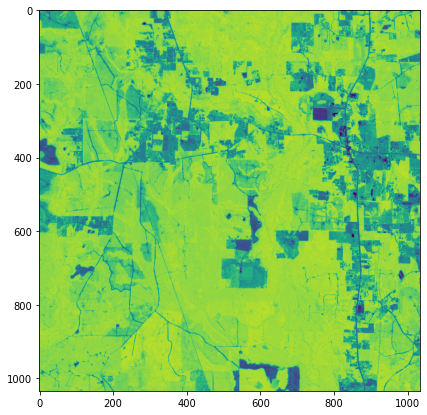

In [ ]:
path_to_B04 = "data/sentinel-2/tx=37,ty=-332/20221010_B04.tif"
path_to_B08 = "data/sentinel-2/tx=37,ty=-332/20221010_B08.tif"
B04 = rasterio.open(path_to_B04).read(1)/10000
B08 = rasterio.open(path_to_B08).read(1)/10000
ndvi = get_index(B08, B04)
plt.figure(figsize=(7,7))
plt.imshow(ndvi, vmin=0, vmax=1)
plt.show()

#### Loading ground truth data

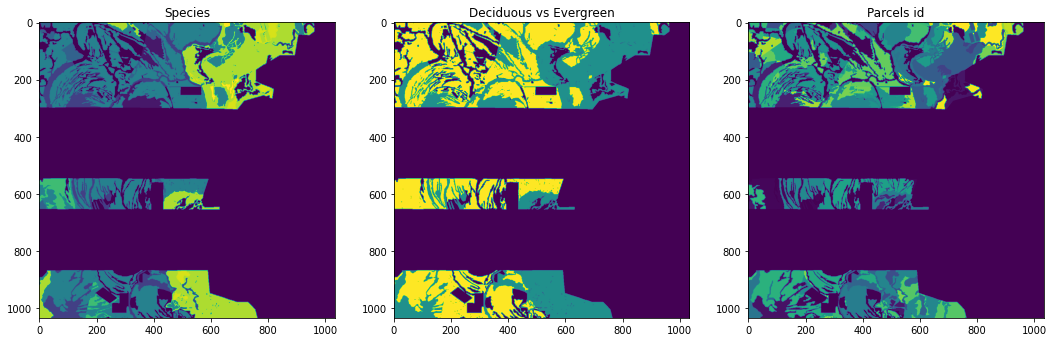

In [ ]:
# Get path to raster
path_to_raster = "data/ground_truth/tx=38,ty=-331.tif"
raster =  rasterio.open(path_to_raster)

species = raster.read(1)
deciduous_evergreen = raster.read(2)
parcel_id = raster.read(3)

# replacing nodata values
mask = (parcel_id==9999)
species[mask]=-1
deciduous_evergreen[mask]=-1
parcel_id[mask]=-1

fig, ax = plt.subplots(1,3, figsize=(18,7))
ax[0].imshow(species)
ax[0].set_title("Species")
ax[1].imshow(deciduous_evergreen)
ax[1].set_title("Deciduous vs Evergreen")
ax[2].imshow(parcel_id)
ax[2].set_title("Parcels id")
plt.show()

### Get relation between species id and names

In [6]:
species_indexing = json.load(open("data/ground_truth/species_indexing.json"))
deciduous_evergreen_indexing = json.load(open("data/ground_truth/deciduous_evergreen_indexing.json"))
print(species_indexing)
print()
print(deciduous_evergreen_indexing)

{'6': 'pinus taeda', '2': 'nyssa sylvatica', '0': 'cypress', '13': 'quercus nigra', '14': 'quercus pagoda', '3': 'pinus echinata', '4': 'pinus elliottii', '10': 'quercus laurifolia', '16': 'quercus rubra', '1': 'liquidambar', '5': 'pinus palustris', '15': 'quercus phellos', '8': 'quercus acutissima', '12': 'quercus michauxii', '17': 'quercus shumardii', '11': 'quercus lyrata', '18': 'triadica sebifera', '9': 'quercus falcata', '7': 'pseudotsuga menziesii'}

{'1': 'evergreen', '0': 'deciduous'}


### Usefull links

* Sentinel-2 bands : 
    * https://gisgeography.com/sentinel-2-bands-combinations/
* Sentinel-2 indices : 
    * https://giscrack.com/list-of-spectral-indices-for-sentinel-and-landsat/
* Tree Species Classification with Multi-Temporal Sentinel-2 Data : 
    * https://www.mdpi.com/2072-4292/10/11/1794
* Rasterio documentation : 
    * https://rasterio.readthedocs.io/en/latest/index.html

In [7]:
import os, glob
import datetime
from collections import defaultdict
import re

In [371]:
from skimage.transform import resize
import cv2

In [ ]:
def time_series(data_dir, ground_truth_dir, coordinates, agg_fn=np.mean):

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))

  for coordinate in coordinates:
    parcel_ids = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif')).read(3)

    for f in glob.iglob(os.path.join(data_dir, coordinate, '*_B*.tif')):
      img = rasterio.open(f).read(1)/10000

      # some bands have different sizes / pixel resolution (e.g. B11)
      for id in np.unique(parcel_ids):
        if parcel_ids.shape == img.shape:
          value = agg_fn(img[parcel_ids == id])
        else:
          value = agg_fn(resize(img, parcel_ids.shape)[parcel_ids == id])

        # extract band and date info from filename
        date, band = re.findall('[0-9]{8}_B[0-9]{2}', f)[0].split('_')
        date = datetime.datetime.strptime(date, '%Y%m%d').date()

        data[coordinate][(band,id)][date] = value
      
  return data

In [367]:
def simple_index(img_dict, bands):
  band1, band2 = (img_dict[bb] for bb in bands)
  shape_1 = band1.shape
  shape_2 = band2.shape
  if np.sum(shape_1)>np.sum(shape_2):
      band2 = cv2.resize(band2, (shape_1[0], shape_1[1]))
  if np.sum(shape_2)>np.sum(shape_2):
      band1 = cv2.resize(band1, (shape_2[0], shape_2[1]))
  return (band1 - band2) / (band1 + band2 + 1e-7)

def evi(img_dict, bands):
  B08, B04, B02 = (img_dict[bb] for bb in bands)
  return 2.5 * (B08 - B04) / (B08 + 6 * B04 - 7.5 * B02 + 1 + 1e-7)

def avi(img_dict, bands):
  B08, B04 = (img_dict[bb] for bb in bands)
  base = (B08 * (1 - B04)*(B08 - B04))
  return np.sign(base) * np.abs(base) ** (1/3)

In [563]:
def index_time_series(data_dir, ground_truth_dir, coordinates, indices, agg_fns=[np.mean]):

  # store data in a dict (to be converted to pd.DataFrame later)
  data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: np.nan)))

  band_list = set(bb for b in indices.values() for bb in b[1])

  for coordinate in coordinates:
    parcel_ids = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif')).read(3)

    for date in set(f.split('_')[-2].split('/')[-1] for f in glob.iglob(os.path.join(data_dir, coordinate, '*_B*.tif'))):
      
      clouds = rasterio.open(os.path.join(data_dir, coordinate, f'{date}_SCL.tif')).read(1).astype(bool)
      
      bands = {
          band: rasterio.open(os.path.join(data_dir, coordinate, f'{date}_{band}.tif')).read(1)/10000
          for band in band_list
      }

      date = datetime.datetime.strptime(date, '%Y%m%d').date()

      for index, (fun, args) in indices.items():
        img = fun(bands, args)
        for id in set(parcel_ids.flatten()) - {9999}:
          pixel_coords = (parcel_ids == id) & ~clouds
          if pixel_coords.any():
            for agg_fn in agg_fns:
              data[coordinate][(index, agg_fn.__name__, id)][date] = agg_fn(img[pixel_coords])
      
  return pd.concat([
      pd.DataFrame(v, columns=pd.MultiIndex.from_tuples(v.keys(), names=["band", "agg", "parcel"])) 
      for v in data.values()], axis='columns').sort_index()

In [564]:
indices = {
    'ndvi': (simple_index, ('B08', 'B04')),
    'gndvi': (simple_index, ('B08', 'B03')),
    'ndmi': (simple_index, ('B08', 'B11')),
    'evi': (evi, ('B08', 'B04', 'B02')),
    'avi': (avi, ('B08', 'B04')),
}

In [565]:
index_df = index_time_series(
    data_dir='data/sentinel-2', 
    ground_truth_dir='data/ground_truth', 
    coordinates=[os.path.basename(d) for d in glob.iglob('data/sentinel-2/*')],
    indices=indices,
    agg_fns=[np.mean, np.std, np.median]
)

In [566]:
index_df.to_pickle('index_all_data.pkl')

---
To deal with later: some parcels may stretch over multiple tiffs:

In [ ]:
all_ids = []
for gt in glob.iglob('data/ground_truth/*.tif'):
  parcel_id = rasterio.open(gt).read(3)
  all_ids.extend(np.unique(parcel_id).tolist())

In [ ]:
len(all_ids)

548

In [ ]:
len(set(all_ids))

485

---

# Classes

In [596]:
def classes(ground_truth_dir, coordinates):

  species_dict = {}
  deciduous_evergreen_dict = {}
  
  for coordinate in coordinates:
    raster = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif'))
    species = raster.read(1)
    deciduous_evergreen = raster.read(2)
    parcel_id = raster.read(3)

    for id in set(parcel_id.flatten()) - {9999}:
      species_dict[id] = np.unique(species[parcel_id == id]).item()
      deciduous_evergreen_dict[id] = np.unique(deciduous_evergreen[parcel_id == id]).item()
    
  return species_dict, deciduous_evergreen_dict

In [597]:
species_dict, deciduous_evergreen_dict = classes(
  ground_truth_dir='data/ground_truth', 
  coordinates=[os.path.basename(d) for d in glob.iglob('data/sentinel-2/*')])

In [598]:
pd.Series(deciduous_evergreen_dict).value_counts(normalize=True)

1    0.780992
0    0.219008
dtype: float64

In [599]:
pd.Series(species_dict).value_counts(normalize=False)

6     349
13     52
0      17
4      16
14     11
2      10
5      10
1       8
15      5
10      3
16      1
8       1
9       1
dtype: int64

In [ ]:
pd.Series(species_dict).value_counts(normalize=True)

6       0.719588
13      0.107216
0       0.035052
4       0.032990
14      0.022680
2       0.020619
5       0.020619
1       0.016495
15      0.010309
10      0.006186
9999    0.002062
16      0.002062
8       0.002062
9       0.002062
dtype: float64

In [ ]:
def parcel_area(ground_truth_dir, coordinates):

  area = defaultdict(lambda: 0)
  
  for coordinate in coordinates:
    raster = rasterio.open(os.path.join(ground_truth_dir, coordinate+'.tif'))
    parcel_id = raster.read(3)

    for id in np.unique(parcel_id):
      area[id] += (parcel_id == id).sum()
    
  return dict(area)

In [ ]:
parcel_area_dict = parcel_area(
  ground_truth_dir='data/ground_truth', 
  coordinates=[os.path.basename(d) for d in glob.iglob('data/sentinel-2/*')])

In [ ]:
pd.concat([
    pd.Series(species_dict).astype(str).replace(species_indexing).value_counts().drop('9999').rename('parcels'),
    pd.concat([pd.Series(species_dict).astype(str).replace(species_indexing), pd.Series(parcel_area_dict)], axis=1).groupby(0).sum()[1].drop('9999').rename('area')
], axis=1).to_markdown()


'|                    |   parcels |   area |\n|:-------------------|----------:|-------:|\n| pinus taeda        |       349 | 907809 |\n| quercus nigra      |        52 | 221411 |\n| cypress            |        17 |  73513 |\n| pinus elliottii    |        16 |  42433 |\n| quercus pagoda     |        11 |  39071 |\n| nyssa sylvatica    |        10 |  59018 |\n| pinus palustris    |        10 |   9112 |\n| liquidambar        |         8 |  19212 |\n| quercus phellos    |         5 |   7360 |\n| quercus laurifolia |         3 |  14961 |\n| quercus rubra      |         1 |   2487 |\n| quercus acutissima |         1 |    309 |\n| quercus falcata    |         1 |    172 |'

---

# Feature extraction

In [568]:
index_df = pd.read_pickle('index_all_data.pkl')

In [569]:
index_df.head()

band            ndvi                                                    \
agg             mean       std    median      mean       std    median   
parcel          641       641       641       2306      2306      2306   
2018-12-10  0.812609  0.052248  0.819525  0.378466  0.069147  0.366466   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24  0.804319  0.085492  0.828571  0.351576  0.058265  0.339781   
2019-01-29  0.822221  0.048504  0.830052  0.344621  0.057982  0.331887   
2019-02-13  0.764347  0.100629  0.798882  0.319411  0.054081  0.308322   

band                                                ...       avi            \
agg             mean       std    median      mean  ...    median      mean   
parcel          1547      1547      1547      1426  ...      300       1012   
2018-12-10  0.679212  0.104521  0.693744  0.835592  ...  0.175186  0.382113   
2018-12-15       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2019-01-24  0.508801  0.107520  0.513025  0.845308  ...  0.142702  0.382466   
2019-01-29  0.508035  0.058047  0.503546  0.832909  ...  0.140573  0.387098   
2019-02-13  0.462074  0.086844  0.461109  0.817738  ...  0.139702  0.364591   

band                                                                    \
agg              std    median      mean       std    median      mean   
parcel          1012      1012      1909      1909      1909      254    
2018-12-10  0.012419  0.381962  0.343544  0.034148  0.342771  0.262955   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24  0.010646  0.381929  0.340035  0.032717  0.339300  0.195013   
2019-01-29  0.011027  0.385823  0.352580  0.032352  0.351022  0.195723   
2019-02-13  0.015285  0.365569  0.337198  0.027059  0.335983  0.179982   

band                            
agg              std    median  
parcel          254       254   
2018-12-10  0.071510  0.260052  
2018-12-15       NaN       NaN  
2019-01-24  0.081786  0.161596  
2019-01-29  0.086640  0.157557  
2019-02-13  0.085098  0.149254  

[5 rows x 8115 columns]

In [570]:
def winter_over_summer(df):

  winter = df.loc[[m in (12,1,2) for m in pd.DatetimeIndex(df.index).month]].mean()
  summer = df.loc[[m in  (6,7,8) for m in pd.DatetimeIndex(df.index).month]].mean()

  return winter / summer

In [15]:
def winter_diff_summer(df):

  winter = df.loc[[m in (12,1,2) for m in pd.DatetimeIndex(df.index).month]].mean()
  summer = df.loc[[m in  (6,7,8) for m in pd.DatetimeIndex(df.index).month]].mean()

  return summer - winter

In [239]:
def median_derivative(df):
  return df.diff().median()
  # return (df.diff().T / df.index.to_series().diff().dt.days.T).T.median()

In [248]:
def std_derivative(df):
  return df.diff().std()
  # return (df.diff().T / df.index.to_series().diff().dt.days.T).T.median()

In [157]:
def doy_max(df):
  return pd.to_datetime(df.idxmax() + datetime.timedelta(days=31)).dt.day_of_year

In [226]:
def doy_min(df):
  return pd.to_datetime(df.idxmin() + datetime.timedelta(days=31)).dt.day_of_year

In [138]:
def doy_max_derivative(df):
  return pd.to_datetime((df.diff().T / df.index.to_series().diff().dt.days.T).T.idxmax() + datetime.timedelta(days=31)).dt.day_of_year

In [290]:
def min_max_diff(df):
  return df.max() - df.min()

In [574]:
def feature_extraction(df, feature_list):
  X = pd.concat([fun(df[index][agg]) for (fun, index, agg) in feature_list], axis=1)
  X.columns = [index + '_' + agg + '__' + fun.__name__ for (fun, index, agg) in feature_list]
  return X

In [18]:
import itertools

In [575]:
# list of (function, index, agg) tuples
features = list(itertools.product([
    doy_max, 
    # doy_min,
    # doy_max_derivative,
    median_derivative,
    std_derivative,
    winter_over_summer,
    winter_diff_summer,
    pd.DataFrame.std,
    pd.DataFrame.min,
    pd.DataFrame.max,
    min_max_diff,
    pd.DataFrame.mean,
], ['ndvi', 'gndvi', 'ndmi', 'evi', 'avi'],
   ['mean', 'std', 'median']))

---
# Classification: deciduous vs. evergreen

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier

In [602]:
Xy = pd.concat([feature_extraction(index_df, features), pd.Series(deciduous_evergreen_dict)], axis=1)
Xy = Xy.loc[Xy.index != 9999]
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-1]

In [603]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [604]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [605]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [606]:
accuracy_score(y_test, y_pred)

0.9385474860335196

In [607]:
roc_auc_score(y_test, y_pred)

0.9112658994548759

In [608]:
confusion_matrix(y_test, y_pred)

array([[ 44,   8],
       [  3, 124]])

# Classification: species

In [609]:
Xy = pd.concat([feature_extraction(index_df, features), pd.Series(species_dict)], axis=1)
Xy = Xy.loc[Xy.index != 9999]
X = Xy.iloc[:,:-1].to_numpy()
y = Xy.iloc[:,-1].to_numpy()

In [610]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [611]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [612]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [613]:
accuracy_score(y_test, y_pred)

0.8435754189944135

In [614]:
balanced_accuracy_score(y_test, y_pred)

0.2688043638508035

---

## Yearly time series

In [615]:
yearly_df = pd.concat([
    index_df.interpolate().loc[datetime.datetime.strptime(f'{y}1201', '%Y%m%d').date():datetime.datetime.strptime(f'{y+1}1130', '%Y%m%d').date()]
    for y in range(index_df.index.min().year, index_df.index.max().year)
], axis=1)

In [181]:
# yearly_df = yearly_df.set_index((pd.DatetimeIndex(yearly_df.index)+datetime.timedelta(days=31)).day_of_year).groupby(level=0).median()
# yearly_df.set_index()

In [616]:
yearly_df

band            ndvi                                                    \
agg             mean       std    median      mean       std    median   
parcel          641       641       641       2306      2306      2306   
2018-12-10  0.812609  0.052248  0.819525  0.378466  0.069147  0.366466   
2018-12-15  0.808464  0.068870  0.824048  0.365021  0.063706  0.353123   
2019-01-24  0.804319  0.085492  0.828571  0.351576  0.058265  0.339781   
2019-01-29  0.822221  0.048504  0.830052  0.344621  0.057982  0.331887   
2019-02-13  0.764347  0.100629  0.798882  0.319411  0.054081  0.308322   
...              ...       ...       ...       ...       ...       ...   
2022-10-10       NaN       NaN       NaN       NaN       NaN       NaN   
2022-10-15       NaN       NaN       NaN       NaN       NaN       NaN   
2022-10-20       NaN       NaN       NaN       NaN       NaN       NaN   
2022-10-25       NaN       NaN       NaN       NaN       NaN       NaN   
2022-11-09       NaN       NaN       NaN       NaN       NaN       NaN   

band                                                ...       avi            \
agg             mean       std    median      mean  ...    median      mean   
parcel          1547      1547      1547      1426  ...      300       1012   
2018-12-10  0.679212  0.104521  0.693744  0.835592  ...       NaN       NaN   
2018-12-15  0.594006  0.106020  0.603384  0.840450  ...       NaN       NaN   
2019-01-24  0.508801  0.107520  0.513025  0.845308  ...       NaN       NaN   
2019-01-29  0.508035  0.058047  0.503546  0.832909  ...       NaN       NaN   
2019-02-13  0.462074  0.086844  0.461109  0.817738  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2022-10-10       NaN       NaN       NaN       NaN  ...  0.322570  0.334714   
2022-10-15       NaN       NaN       NaN       NaN  ...  0.312518  0.338207   
2022-10-20       NaN       NaN       NaN       NaN  ...  0.315920  0.333406   
2022-10-25       NaN       NaN       NaN       NaN  ...  0.314653  0.345162   
2022-11-09       NaN       NaN       NaN       NaN  ...  0.314653  0.345162   

band                                                                    \
agg              std    median      mean       std    median      mean   
parcel          1012      1012      1909      1909      1909      254    
2018-12-10       NaN       NaN       NaN       NaN       NaN       NaN   
2018-12-15       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-24       NaN       NaN       NaN       NaN       NaN       NaN   
2019-01-29       NaN       NaN       NaN       NaN       NaN       NaN   
2019-02-13       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-10-10  0.025315  0.324659  0.363963  0.022305  0.363549  0.354761   
2022-10-15  0.028264  0.334866  0.356055  0.022852  0.355778  0.349504   
2022-10-20  0.021328  0.332437  0.364242  0.022392  0.363670  0.357667   
2022-10-25  0.030736  0.338218  0.365814  0.024666  0.366314  0.359080   
2022-11-09  0.030736  0.338218  0.365814  0.024666  0.366314  0.359080   

band                            
agg              std    median  
parcel          254       254   
2018-12-10       NaN       NaN  
2018-12-15       NaN       NaN  
2019-01-24       NaN       NaN  
2019-01-29       NaN       NaN  
2019-02-13       NaN       NaN  
...              ...       ...  
2022-10-10  0.032201  0.357357  
2022-10-15  0.034539  0.353276  
2022-10-20  0.036600  0.360875  
2022-10-25  0.039352  0.362691  
2022-11-09  0.039352  0.362691  

[90 rows x 32460 columns]

In [617]:
# Xy = pd.concat([feature_extraction(yearly_df, features), feature_extraction(yearly_std_df, features, suffix='_std'), pd.Series(species_dict)], axis=1)
# Xy = pd.concat([feature_extraction(yearly_median_df, features), pd.Series(species_dict)], axis=1)
Xy = pd.concat([feature_extraction(yearly_df, features), pd.Series(species_dict)], axis=1)
Xy = Xy.loc[Xy.index != 9999]
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-1]

In [618]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [619]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [620]:
accuracy_score(y_pred, y_test)

0.8447552447552448

In [621]:
balanced_accuracy_score(y_test, y_pred)

0.32357792456991896

In [622]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.9204777482661973

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

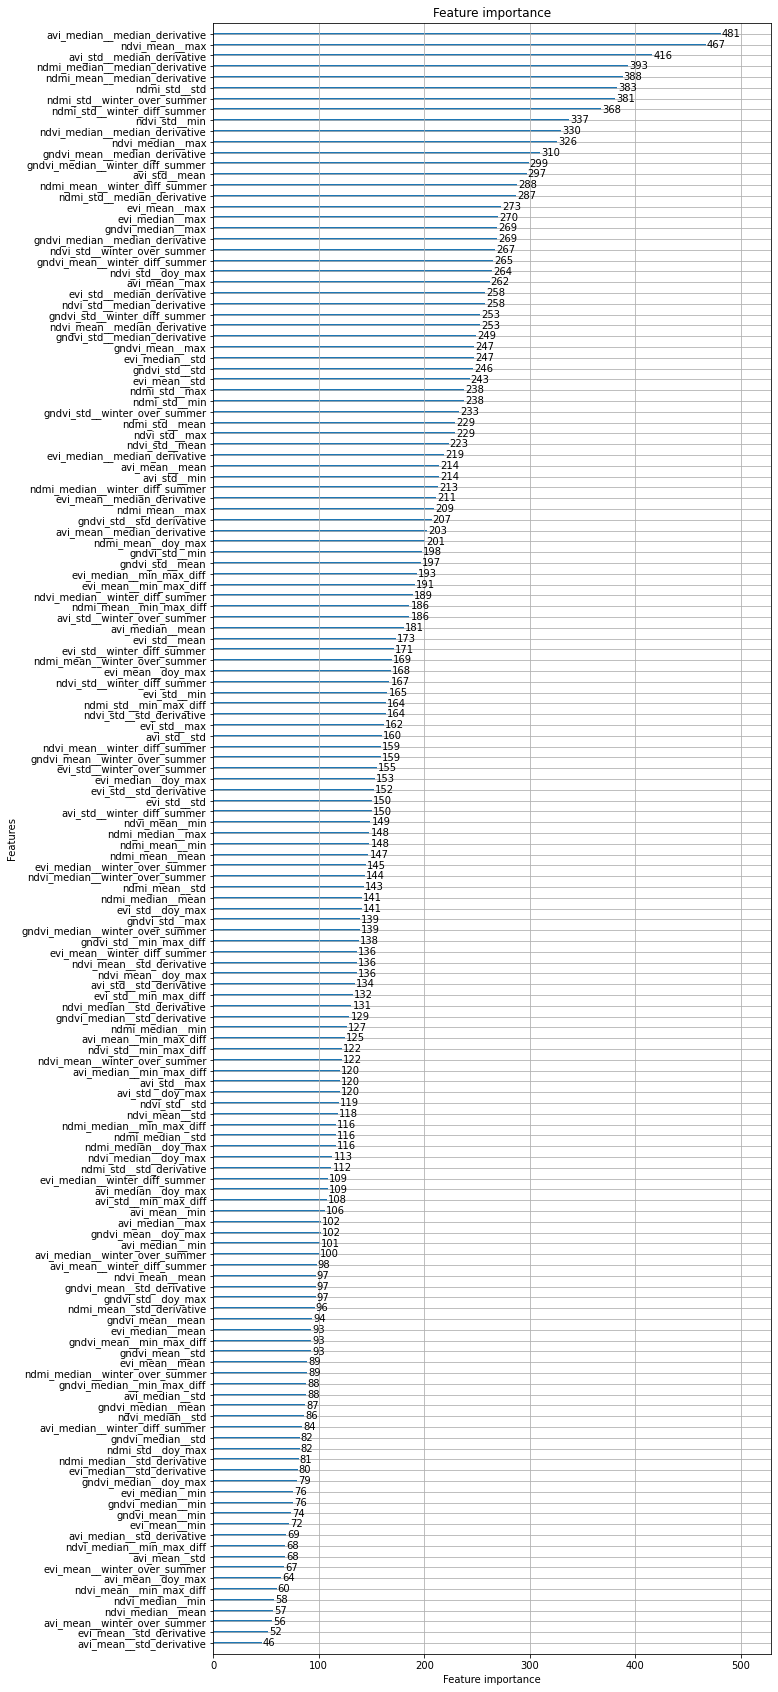

In [625]:
from lightgbm import plot_importance
plot_importance(model, figsize=(10,30))

In [624]:
np.array(model.feature_name_)[model.feature_importances_ == 0]

array([], dtype='<U32')

## Imbalance

In [219]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [220]:
from imblearn.over_sampling import RandomOverSampler

In [626]:
oversampler = RandomOverSampler()
X_over, y_over = oversampler.fit_resample(X_train, y_train)

In [627]:
model = LGBMClassifier()
model.fit(X_over, y_over)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [628]:
accuracy_score(y_test, y_pred)

0.8391608391608392

In [629]:
balanced_accuracy_score(y_test, y_pred)

0.351642120207209

In [630]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

0.9180627963756339